In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import read_geolife
import tracers as tr
import matplotlib.pyplot as plt
from pyproj import Transformer
import math
import seaborn as sns

In [3]:
traces = []
processed_traces = []  

for i in range(15):
    traces.extend(read_geolife.read_all_of_user(f"{i:03}")) 
for trace in traces:
    # Convert timestamp to epoch
    trace['Datetime'] = pd.to_datetime(trace['Datetime']).astype(int) / 10**9  
    # Sort by time
    trace = trace.sort_values(by='Datetime')
    # Convert to array (lon, lat, timestamp)
    trace = trace[['Longitude', 'Latitude', 'Datetime']].to_numpy()
    # Convert to list of tuples
    trace = [tuple(x) for x in trace]
    # Ensure timestamp is an integer
    trace = [(x[0], x[1], int(x[2])) for x in trace]
    
    processed_traces.append(trace) 

# Replace traces with processed version
traces = processed_traces

In [4]:
(space_noise, time_min_period) = (300.0, 90)
perturbed_traces = tr.perturb_traces(
    (space_noise, time_min_period), traces)

In [5]:
print(len(traces))
print(len(perturbed_traces))

2247
2247


In [6]:
lat_noise = []
lon_noise = []
angles = []
wgs84_to_utm = Transformer.from_crs(4326, 4547, always_xy=True)

for trace_idx in range(len(traces)):
    for point_idx in range(len(traces[trace_idx])):
        # Convert the coordinates from angles to meters (UTM zone 52N)
        perturbed_traces_lat,perturbed_traces_lon = wgs84_to_utm.transform(perturbed_traces[trace_idx][point_idx][0],
                                                                           perturbed_traces[trace_idx][point_idx][1])
        traces_lat,traces_lon = wgs84_to_utm.transform(traces[trace_idx][point_idx][0],
                                                       traces[trace_idx][point_idx][1]) 


        #Get the angles between points
        if point_idx == 0:
            prev_lat = traces_lat
            prev_lon = traces_lon
        else:
            lon_noise.append(perturbed_traces_lon - traces_lon)
            lat_noise.append(perturbed_traces_lat - traces_lat)
            angles.append(math.atan2(traces_lat-prev_lat,traces_lon-prev_lon))
            prev_lat = traces_lat
            prev_lon = traces_lon

In [7]:
print(len(angles))
print(len(lat_noise))

3696555
3696555


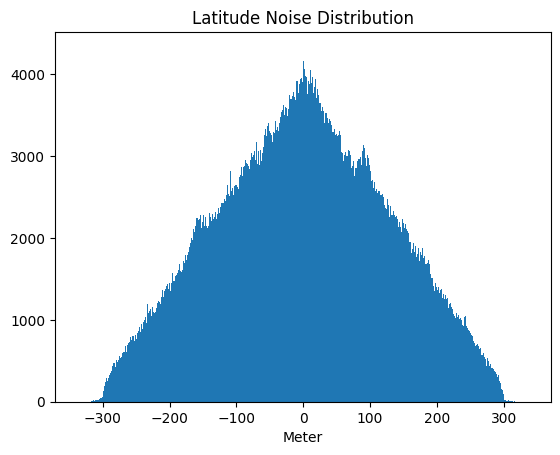

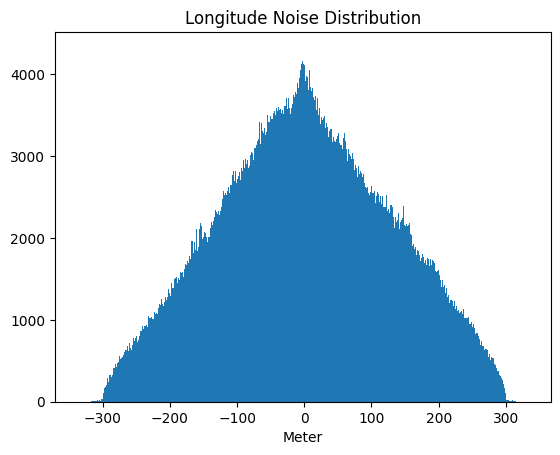

Mean lat noise:  -0.3008923809616218
Stdev lat noise:  128.561661456116
Mean lon noise:  2.0387859563826485
Stdev lon noise:  128.47641757302299


In [8]:
plt.hist(lat_noise, bins=2000)
plt.title('Latitude Noise Distribution')
plt.xlabel('Meter')
plt.show()

plt.hist(lon_noise, bins=2000)
plt.title('Longitude Noise Distribution')
plt.xlabel('Meter')
plt.show()

print("Mean lat noise: ", np.mean(lat_noise))
print("Stdev lat noise: ", np.std(lat_noise))
print("Mean lon noise: ", np.mean(lon_noise))
print("Stdev lon noise: ", np.std(lon_noise))

### Noise angle

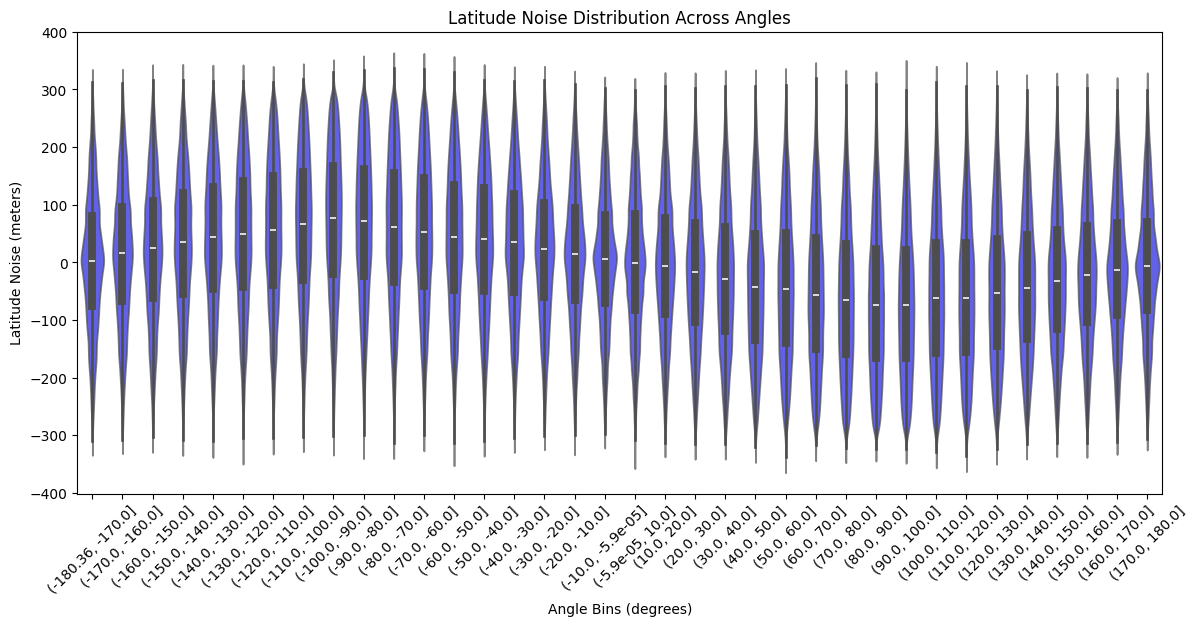

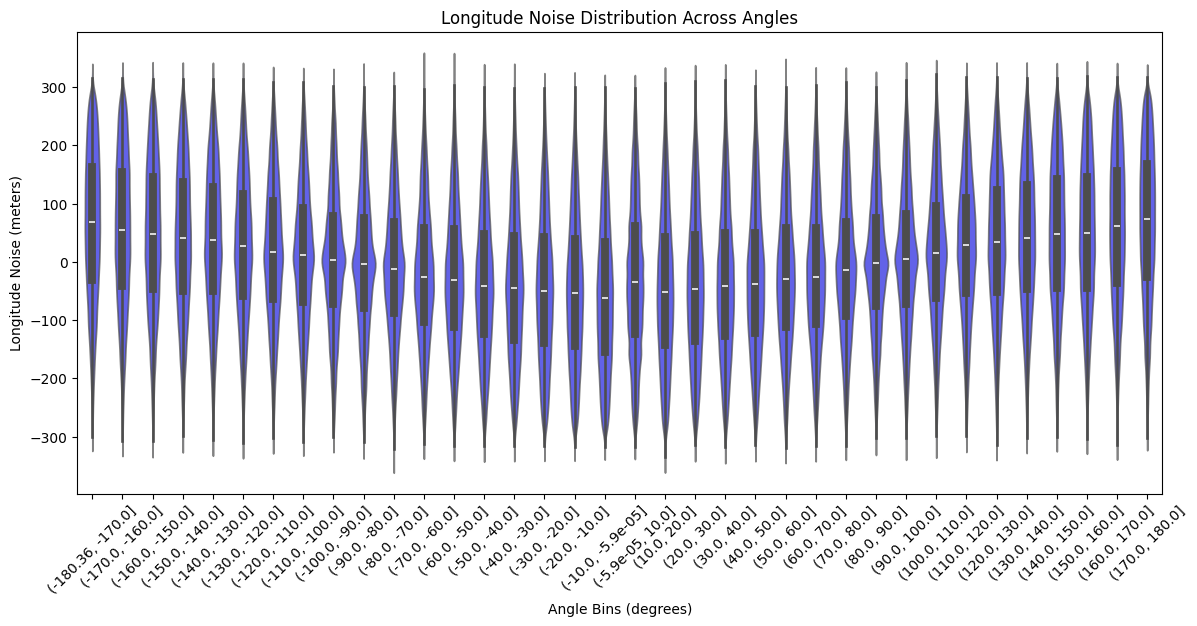

In [9]:
angles_deg = np.degrees(angles)

# Violin plot to show distribution
plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lat_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Latitude Noise (meters)")
plt.title("Latitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lon_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Longitude Noise (meters)")
plt.title("Longitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()


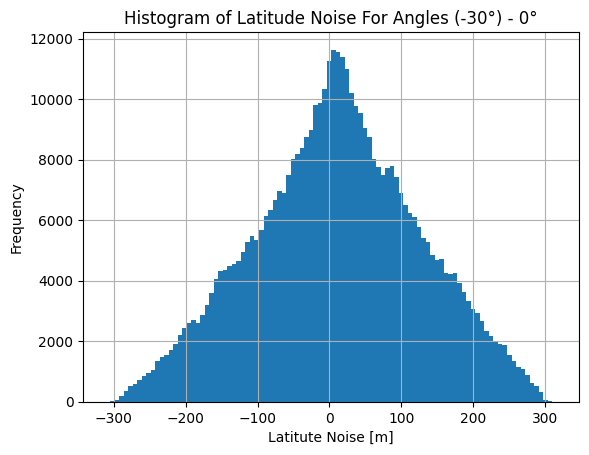

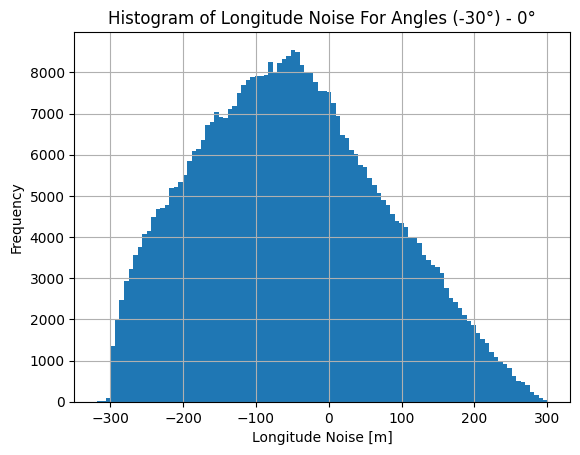

In [10]:
#angle range
angle_min = -30
angle_max = 0

selected_indices = (angles_deg >= angle_min) & (angles_deg < angle_max)
selected_lon_noise = np.array(lon_noise)[selected_indices]
selected_lat_noise = np.array(lat_noise)[selected_indices]

plt.hist(selected_lat_noise, bins=100)
plt.xlabel("Latitute Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Latitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()

plt.hist(selected_lon_noise, bins=100)
plt.xlabel("Longitude Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Longitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()


/tmp/ipykernel_564/2067388360.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


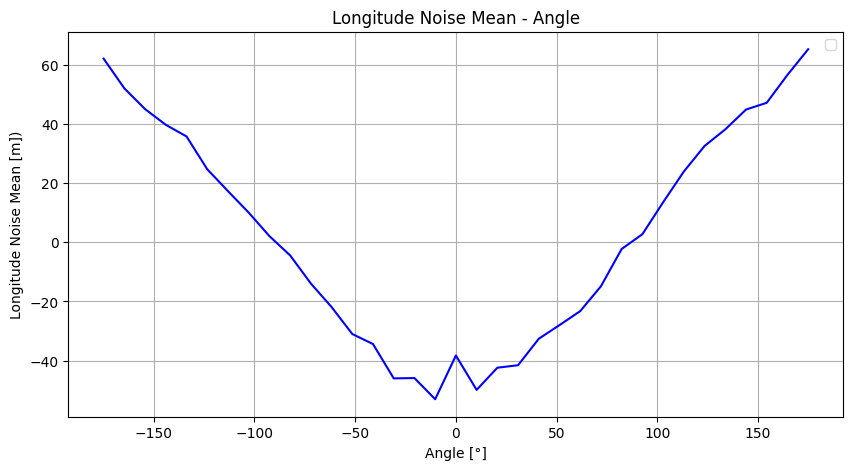

/tmp/ipykernel_564/2067388360.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


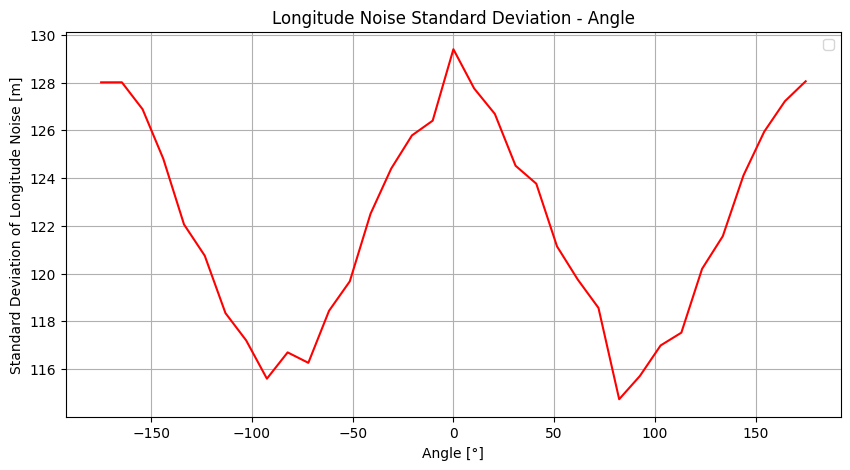

/tmp/ipykernel_564/2067388360.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


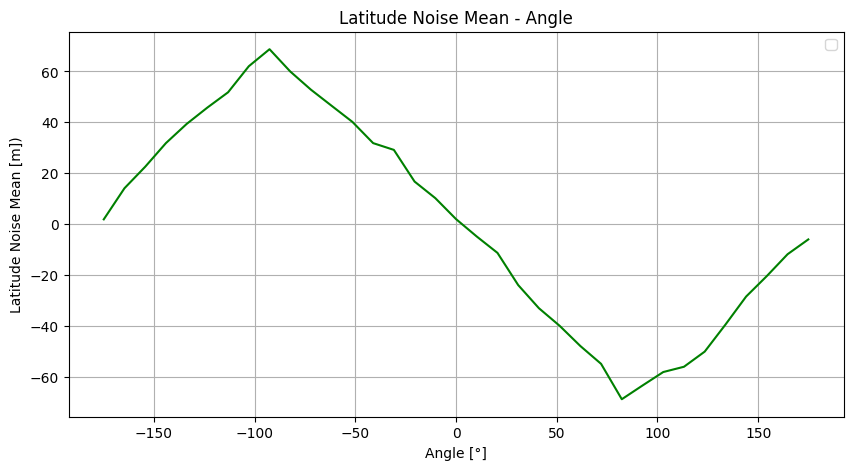

/tmp/ipykernel_564/2067388360.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


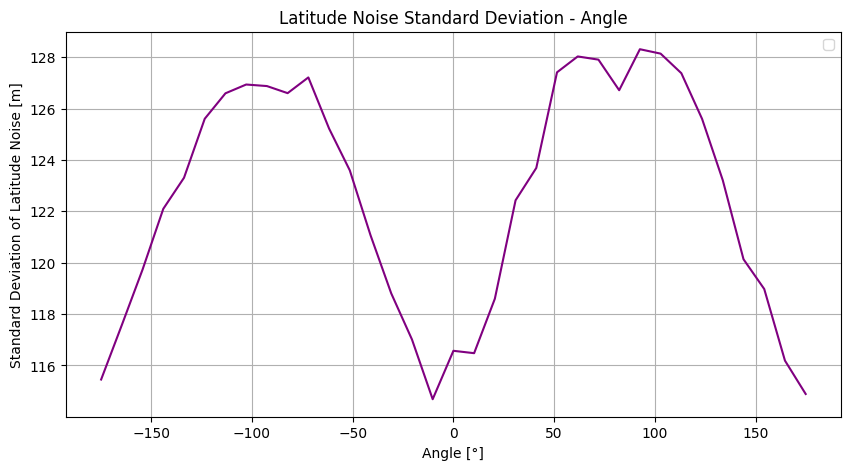

In [ ]:
# Define angle bins
num_bins = 36  
angle_bins = np.linspace(min(angles_deg), max(angles_deg), num_bins)
angle_indices = np.digitize(angles_deg, angle_bins) - 1  


angle_bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2
lon_means, lon_std_devs, lat_means, lat_std_devs = [], [], [], []

for i in range(len(angle_bin_centers)):
    lon_values_in_bin = [lon_noise[j] for j in range(len(lon_noise)) if angle_indices[j] == i]
    lat_values_in_bin = [lat_noise[j] for j in range(len(lat_noise)) if angle_indices[j] == i]
    
    if len(lon_values_in_bin) > 1:  
        lon_means.append(np.mean(lon_values_in_bin))
        lon_std_devs.append(np.std(lon_values_in_bin))
    if len(lat_values_in_bin) > 1:
        lat_means.append(np.mean(lat_values_in_bin))
        lat_std_devs.append(np.std(lat_values_in_bin))

#longitude noise
plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lon_means, color="blue")
plt.xlabel("Angle [°]")
plt.ylabel("Longitude Noise Mean [m])")
plt.title("Longitude Noise Mean - Angle")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lon_std_devs, color="red")
plt.xlabel("Angle [°]")
plt.ylabel("Standard Deviation of Longitude Noise [m]")
plt.title("Longitude Noise Standard Deviation - Angle")
plt.legend()
plt.grid()
plt.show()

#latitude noise 
plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lat_means, color="green")
plt.xlabel("Angle [°]")
plt.ylabel("Latitude Noise Mean [m]")
plt.title("Latitude Noise Mean - Angle")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle_bin_centers, lat_std_devs, color="purple")
plt.xlabel("Angle [°]")
plt.ylabel("Standard Deviation of Latitude Noise [m]")
plt.title("Latitude Noise Standard Deviation - Angle")
plt.legend()
plt.grid()
plt.show()

